# Project of Fundamentals of Artificial Intelligence and Knowledge Representation year 2022/2023

Made by Riccardo Murgia and Alessio Pellegrino
data source: https://www.kaggle.com/datasets/thedevastator/cancer-patients-and-air-pollution-a-new-link?resource=download

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.preprocessing import OrdinalEncoder
from pgmpy.models import NaiveBayes

%matplotlib inline

# Data import and visualization


In [42]:
data = pd.read_csv('./cancer patient data sets.csv', index_col='index')
data.drop('Patient Id', axis=1, inplace=True)
data['Level'] = OrdinalEncoder(categories=[['Low', 'Medium', 'High']]).fit_transform(data[['Level']])
data.head()

,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,Obesity,...,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level
index,,,,,,,,,,,,,,,,,,,,,
0,33,1,2,4,5,4,3,2,2,4,...,3,4,2,2,3,1,2,3,4,0.0
1,17,1,3,1,5,3,4,2,2,2,...,1,3,7,8,6,2,1,7,2,1.0
2,35,1,4,5,6,5,5,4,6,7,...,8,7,9,2,1,4,6,7,2,2.0
3,37,1,7,7,7,7,6,7,7,7,...,4,2,3,1,4,5,6,7,5,2.0
4,46,1,6,8,7,7,7,6,7,7,...,3,2,4,1,4,2,4,2,3,2.0


In [43]:
data.describe()

,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,Obesity,...,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level
count,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,37.174000,1.402000,3.8400,4.563000,5.165000,4.840000,4.580000,4.380000,4.491000,4.465000,...,3.856000,3.855000,4.240000,3.777000,3.746000,3.923000,3.536000,3.853000,2.926000,1.062000
std,12.005493,0.490547,2.0304,2.620477,1.980833,2.107805,2.126999,1.848518,2.135528,2.124921,...,2.244616,2.206546,2.285087,2.041921,2.270383,2.388048,1.832502,2.039007,1.474686,0.815365
min,14.000000,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,27.750000,1.000000,2.0000,2.000000,4.000000,3.000000,2.000000,3.000000,2.000000,3.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000
50%,36.000000,1.000000,3.0000,5.000000,6.000000,5.000000,5.000000,4.000000,4.000000,4.000000,...,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,1.000000
75%,45.000000,2.000000,6.0000,7.000000,7.000000,7.000000,7.000000,6.000000,7.000000,7.000000,...,5.000000,6.000000,6.000000,5.000000,5.000000,5.000000,5.000000,6.000000,4.000000,2.000000
max,73.000000,2.000000,8.0000,8.000000,8.000000,8.000000,7.000000,7.000000,7.000000,7.000000,...,9.000000,8.000000,9.000000,8.000000,8.000000,9.000000,7.000000,7.000000,7.000000,2.000000


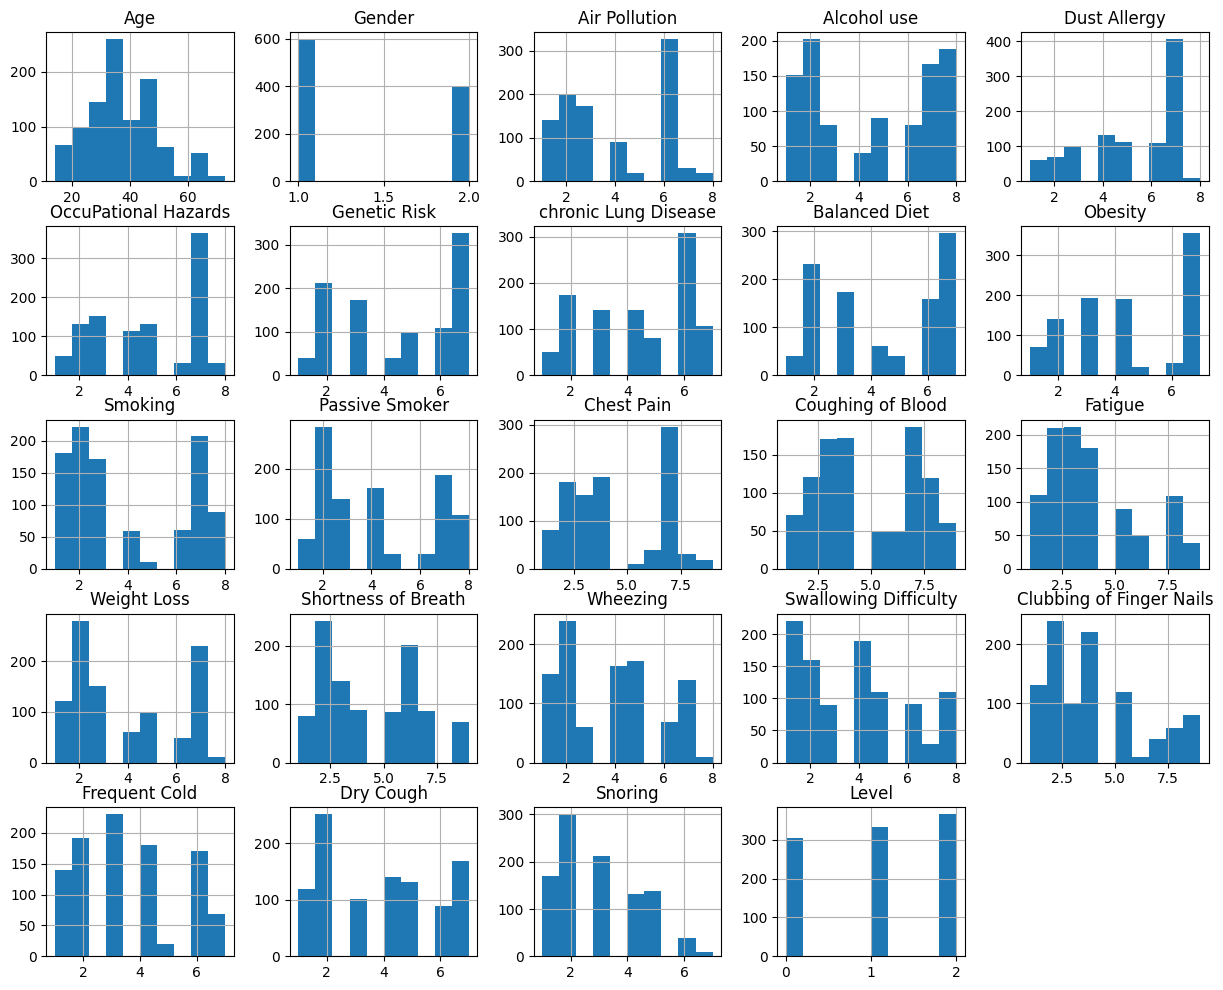

In [44]:
data.hist(figsize=(15,12));

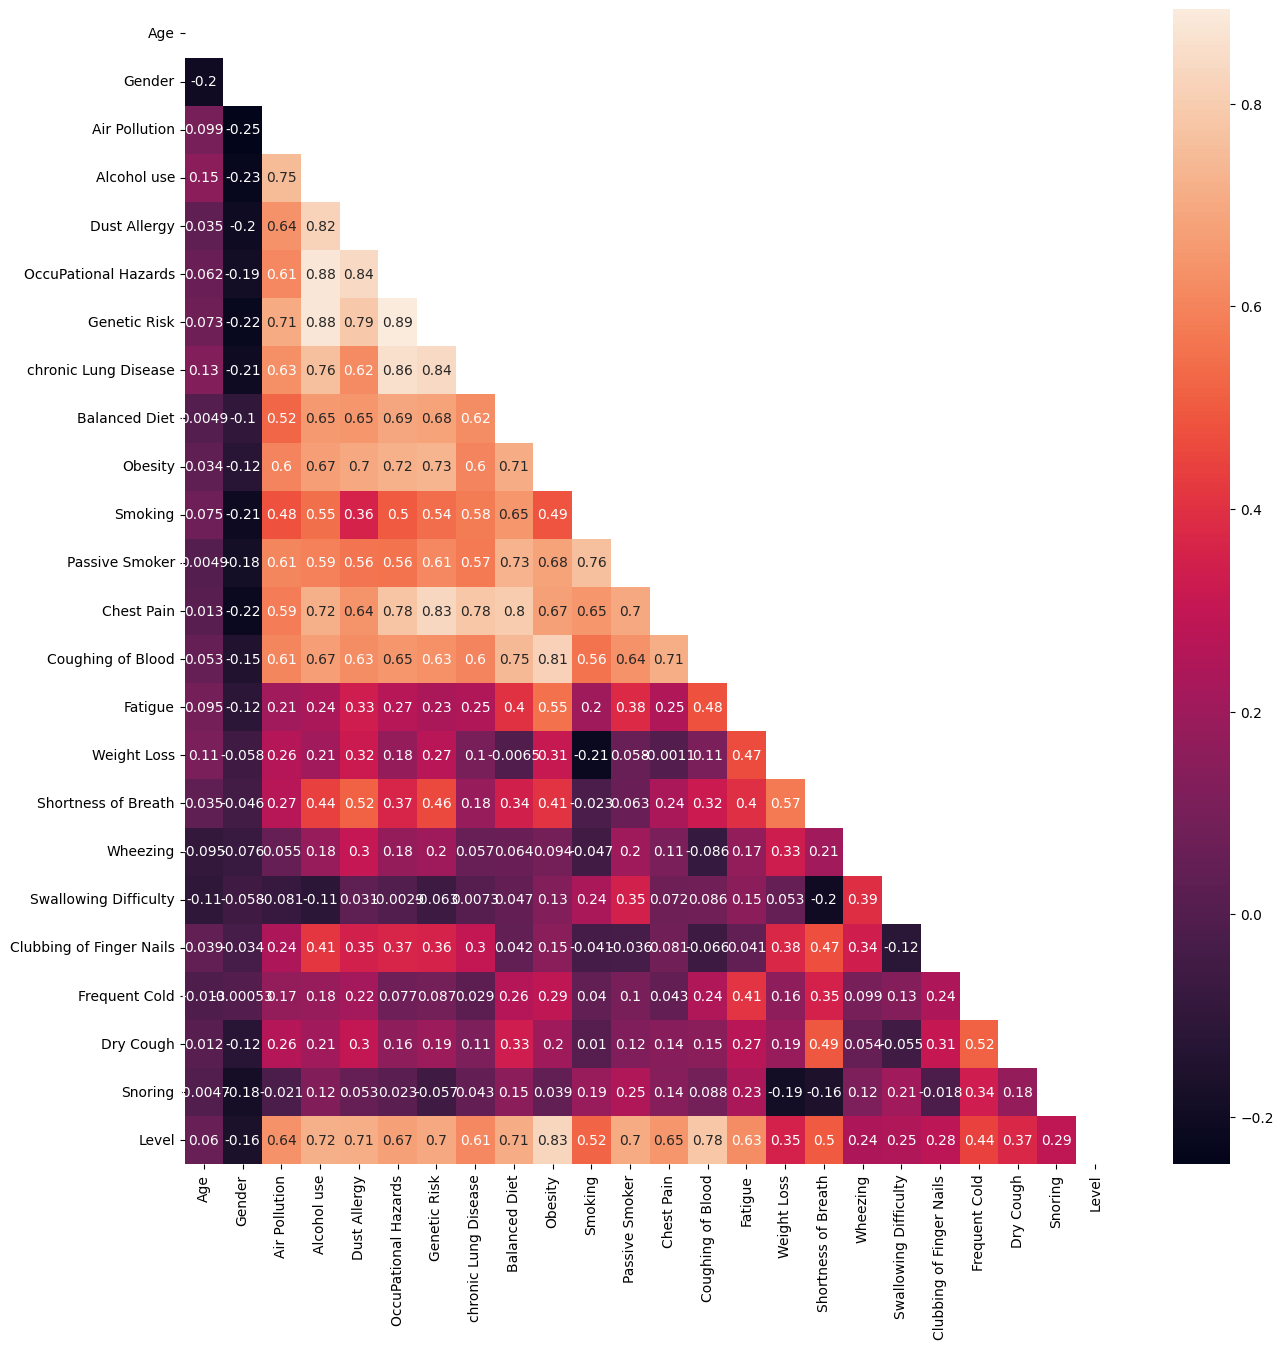

In [45]:
plt.figure(figsize=(15,15))
corr = data.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr,annot=True, mask=mask);

# Classification Process

In [47]:
X = data.drop('Level', axis=1)
y = data['Level']

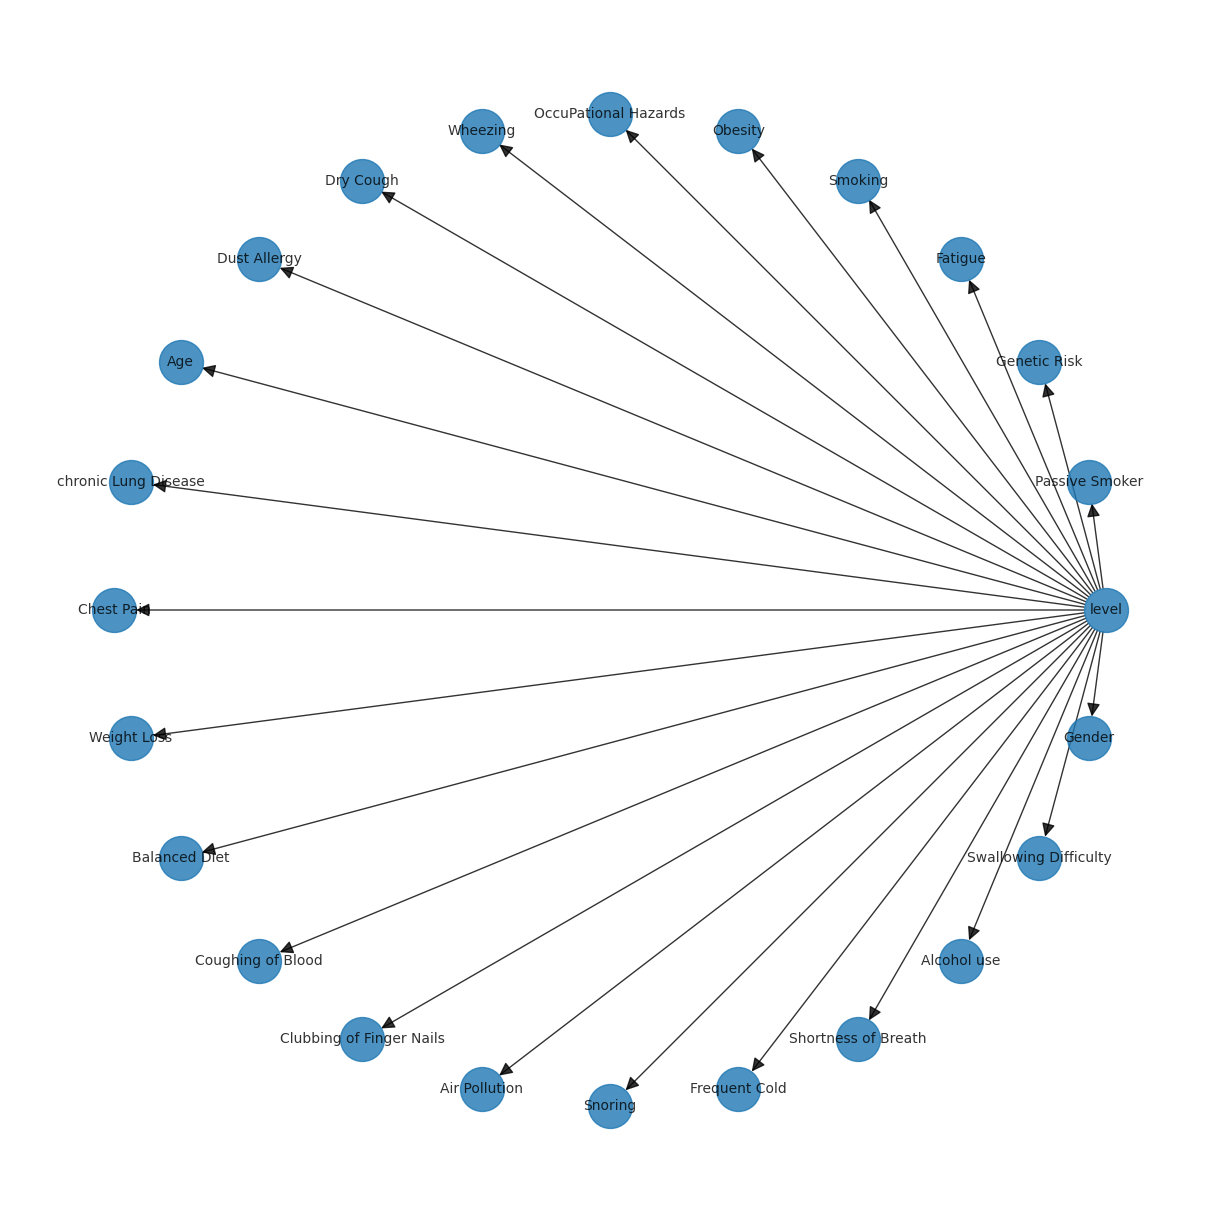

In [50]:
nb_model = NaiveBayes(
    feature_vars=X.columns.values,
    dependent_var='level'
)
plt.figure(figsize=(12,12))
nx.draw_circular(nb_model, with_labels=True, arrowsize=20, node_size=1000, font_size=10, alpha=0.8)
plt.show()